In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


### Required Libraries

In [2]:
import copy
import time
import torch
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

### Parameters

In [3]:
batch_size = 16
input_img_size = 28
validation_size = 0.1
Num_out_features = 10
max_epochs = 20
learning_rate = 0.005

### Data preparation

In [4]:
train_csv = '/kaggle/input/digit-recognizer/train.csv'
test_csv = '/kaggle/input/digit-recognizer/test.csv'

In [5]:
train_val_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_val_label_df = train_val_df['label']
train_val_data_df = train_val_df.drop(['label'], axis = 1)

train_val_data = train_val_data_df.to_numpy()
train_val_label = train_val_label_df.to_numpy()
X_test = test_df.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(train_val_data, train_val_label, 
                                                test_size=validation_size, random_state=42)

print('shape of X_train:', X_train.shape)
print('shape of y_train:', y_train.shape)
print('shape of X_val:', X_val.shape)
print('shape of y_val:', y_val.shape)
print('shape of X_test:', X_test.shape)

shape of X_train: (37800, 784)
shape of y_train: (37800,)
shape of X_val: (4200, 784)
shape of y_val: (4200,)
shape of X_test: (28000, 784)


### Visualize data

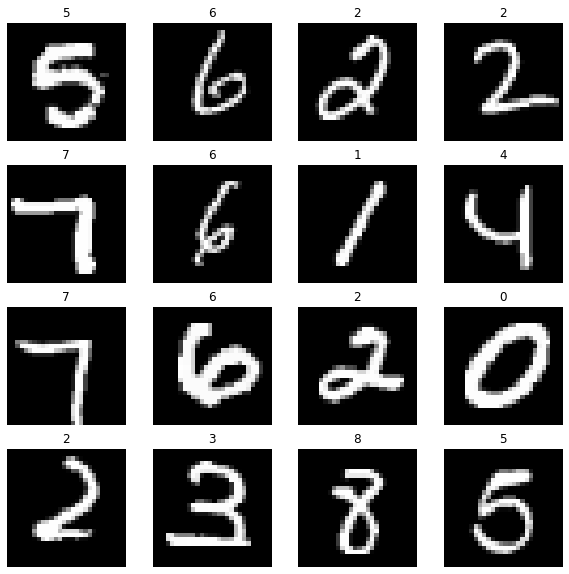

In [6]:
figure = plt.figure(figsize=(10,10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    img = X_train[i]
    lbl = y_train[i]
    figure.add_subplot(rows, cols, i)
    plt.title(str(lbl))
    plt.axis("off")
    plt.imshow(img.reshape(28,28), 'gray')
plt.show()

### Build dataloarders

In [7]:
class DigitDataset(Dataset):
    def __init__(self, data_array, label_array):
        self.data_array = data_array
        self.label_array = label_array
    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, idx):
        image = self.data_array[idx]
        image = image.reshape(28,28)
        image = image/255.
        #PIL_image = Image.fromarray(image.astype('uint8'))
        label = self.label_array[idx]
        label = torch.tensor(label)
        transform = transforms.Compose([
#                                         transforms.Resize(32),
#                                         transforms.RandomCrop(28),
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.RandomVerticalFlip(),
                                        transforms.ToTensor()])
        image = transform(image)
        return (image, label)

In [8]:
Xy_train_obj = DigitDataset(X_train, y_train)
Xy_val_obj = DigitDataset(X_val, y_val)

train_dataloader = DataLoader(Xy_train_obj, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(Xy_val_obj, batch_size=batch_size, shuffle=True)

dataloaders, dataset_sizes = dict(), dict()

dataloaders['train'] = train_dataloader
dataloaders['val'] = val_dataloader
dataset_sizes['train'] = len(train_dataloader.dataset)
dataset_sizes['val'] = len(val_dataloader.dataset)


In [9]:
def trainer(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train': {'acc': [], 'loss':[]}, 'val':{'acc': [], 'loss':[]}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### Finetuning resnet pretrained model

In [10]:
model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, Num_out_features)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Setup required optimizer and loss functions

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train the model

In [12]:
trained_model, history = trainer(model, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=max_epochs)

Epoch 0/19
----------
train Loss: 0.3064 Acc: 0.9181
val Loss: 0.0761 Acc: 0.9762

Epoch 1/19
----------
train Loss: 0.0874 Acc: 0.9762
val Loss: 0.0563 Acc: 0.9845

Epoch 2/19
----------
train Loss: 0.0540 Acc: 0.9839
val Loss: 0.0443 Acc: 0.9874

Epoch 3/19
----------
train Loss: 0.0455 Acc: 0.9876
val Loss: 0.0406 Acc: 0.9862

Epoch 4/19
----------
train Loss: 0.0335 Acc: 0.9908
val Loss: 0.0334 Acc: 0.9888

Epoch 5/19
----------
train Loss: 0.0273 Acc: 0.9924
val Loss: 0.0385 Acc: 0.9855

Epoch 6/19
----------
train Loss: 0.0245 Acc: 0.9930
val Loss: 0.0327 Acc: 0.9907

Epoch 7/19
----------
train Loss: 0.0107 Acc: 0.9972
val Loss: 0.0234 Acc: 0.9936

Epoch 8/19
----------
train Loss: 0.0068 Acc: 0.9980
val Loss: 0.0218 Acc: 0.9943

Epoch 9/19
----------
train Loss: 0.0065 Acc: 0.9981
val Loss: 0.0215 Acc: 0.9943

Epoch 10/19
----------
train Loss: 0.0050 Acc: 0.9986
val Loss: 0.0209 Acc: 0.9936

Epoch 11/19
----------
train Loss: 0.0044 Acc: 0.9989
val Loss: 0.0205 Acc: 0.9936

Ep

### Visaulize training results

In [13]:
train_loss, val_loss = history['train']['loss'], history['val']['loss']
train_acc, val_acc = history['train']['acc'], history['val']['acc']
x_values = np.linspace(0,max_epochs, max_epochs)

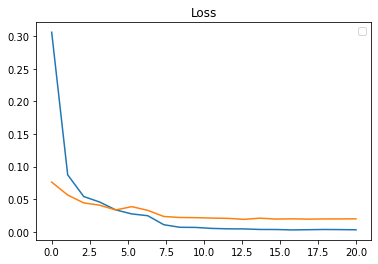

In [14]:
plt.plot(x_values, train_loss)
plt.plot(x_values, val_loss)
plt.legend()
plt.title('Loss')
plt.show()

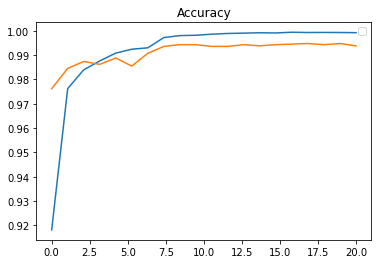

In [15]:
plt.plot(x_values, train_acc)
plt.plot(x_values, val_acc)
plt.legend()
plt.title('Accuracy')
plt.show()

### Display validation results

In [16]:
y_pred = []
trained_model = trained_model.to(device)
for image in X_val:
    image = image.reshape(28,28)
    image = image/255.
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(image).unsqueeze(0)
    img = img.to(device, dtype=torch.float)
    pred = trained_model(img)
    _, pred = torch.max(pred, 1)
    y_pred.append(pred.item())

### Accuracy matrics

In [17]:
validation_accuracy = round(accuracy_score(y_val, y_pred), 3)
actual_lbls = precision_recall_fscore_support(y_val, y_pred)[3]
con_mat = confusion_matrix(y_val, y_pred)
preds_lbls = con_mat.diagonal()

In [18]:
print('Validation accuracy:',validation_accuracy)
print('Digitwise accuracy:')
for i in range(0,Num_out_features):
    act_i, pred_i = actual_lbls[i], preds_lbls[i]
    accuracy_of_digit = round(pred_i/act_i, 3)
    print('{} accuracy:{} [{}/{}]'.format(i, accuracy_of_digit, pred_i, act_i) )

Validation accuracy: 0.995
Digitwise accuracy:
0 accuracy:0.995 [406/408]
1 accuracy:0.998 [470/471]
2 accuracy:0.993 [417/420]
3 accuracy:0.996 [504/506]
4 accuracy:0.995 [395/397]
5 accuracy:1.0 [339/339]
6 accuracy:0.995 [400/402]
7 accuracy:0.991 [434/438]
8 accuracy:0.99 [399/403]
9 accuracy:0.995 [414/416]


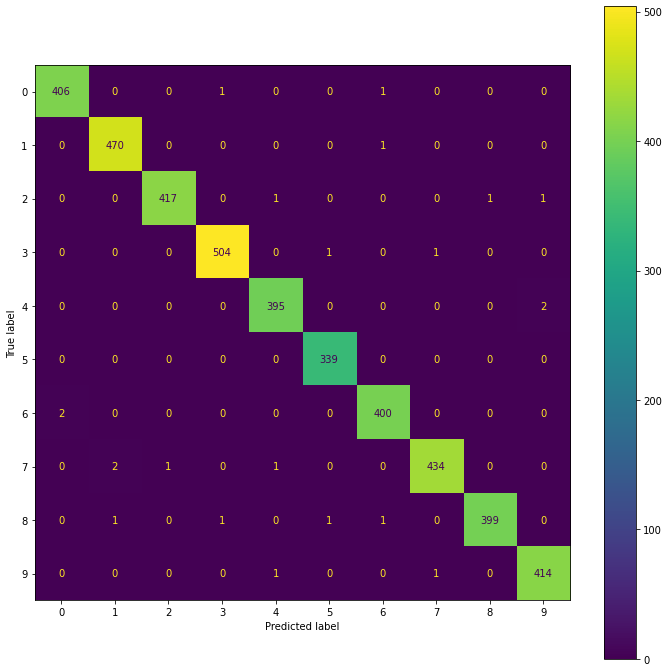

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax = ax) 

### Model testing

In [20]:
y_test = []
for image in X_test:
    image = image.reshape(28,28)
    image = image/255.
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(image).unsqueeze(0)
    img = img.to(device, dtype=torch.float)
    pred = trained_model(img)
    _, pred = torch.max(pred, 1)
    y_test.append(pred.item()) 

### Visualize test results

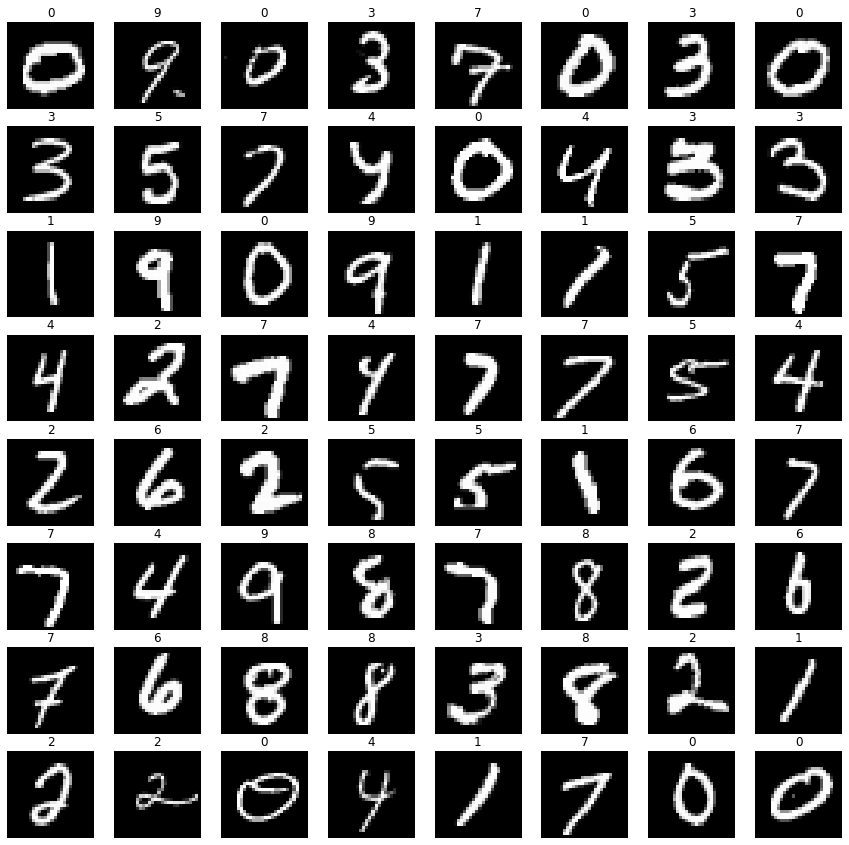

In [21]:
figure = plt.figure(figsize=(15,15))
cols, rows = 8,8
for i in range(1, cols * rows + 1):
    img = X_test[i]
    lbl = y_test[i]
    figure.add_subplot(rows, cols, i)
    plt.title(str(lbl))
    plt.axis("off")
    plt.imshow(img.reshape(28,28), 'gray')
plt.show()

### Save test results

In [22]:
test = dict()
test['ImageId'] = [i for i in range(1,len(y_test)+1)]
test['Label'] =  y_test   
df = pd.DataFrame(test)
df.to_csv('results_new.csv', index=False)